## Lecture notes

### Periodogram Definition

The periodogram $I(f_k)$ is an approximation of the PSD(Power Spectral Density) $S(f)$.
We use the approximation since we do not have infinite data for calculating the PSD

It is defined as

$$
I(f_k)=\frac{1}{N}|X(f_k)|^2
$$

Where $X(f_k)$ is the Discrete Fourier Transform

$$
X(f_k) = \sum_{t=0}^{N-1}x_t e^{-j2\pi f_kt}
$$

The periodogram $I(f_k)$ measures the signals power at frequency $f_k$.

The periodogram can also be computed by using taking the Fourier Transform of the estimated autocorrelation.

$$
I(f_k)=\sum_{h=-(N-1)}^{N-1}\hat{\gamma}(h)e^{-j2\pi f_kt}
$$

Where this expression can be shown to be identical to  the original definition $I(f_k)=\frac{1}{N}|X(f_k)|^2$.

### Power Spectral Density

The power spectral density shows how much of the enery of a signal is in each frequency.

The Einstein-WienerKhinchin theorem states that: The PSD of a WSS random process is given by the fourier transform of it's autocorrelation function.

$$
S(f)=\int_{-\infty}^{\infty} R_x(\tau)e^{-j2\pi \tau} d\tau
$$

However to calculate this we need the true autocorrelation which is not available. Hence, we use the Periodogram instead

## Excercises

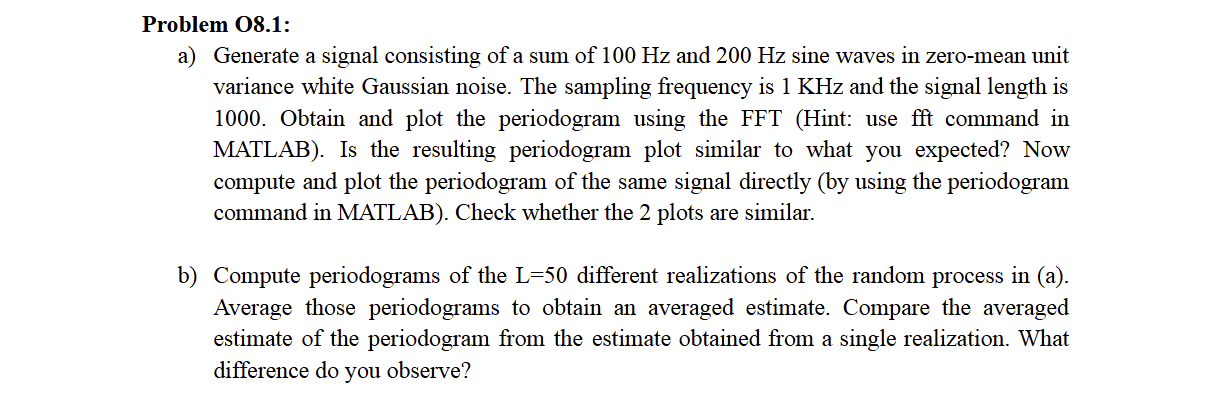

### a)

For the first plot where $I(f_k)=\frac{1}{N}|X(f_k)|^2$ is used, I cet peaks at 100Hz and 200Hz with an amplitude of 250.
For the Scipy Periodogram the peaks have an amplitude of 0.5. 
The reason for this, is that the custom calculation has units $V^2$ and the Scipy Periodogram has units $V^2/Hz$. Also, we need to account for the 2 sided FFT. Hence, we multiply by $2T_s$

(501,) (501,) 0.5063482670868853


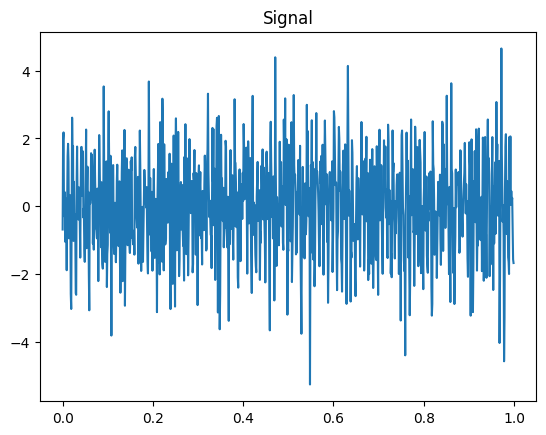

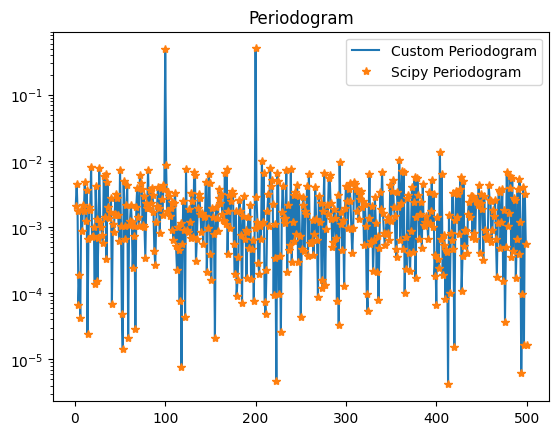

In [26]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

N = 1000
Ts = 0.001
f_1 = 100
f_2 = 200

t = np.arange(N)*Ts

# Generate signal
w = np.random.normal(0, 1, N)
x = np.sin(2*np.pi*f_1*t)+np.sin(2*np.pi*f_2*t)
x += w

# Generate custom Periodogram
X = np.fft.fft(x)
I = 2*Ts*(1/N) * np.abs(X)**2
freqs = np.fft.fftfreq(N, Ts)

# Use scipy Periodogram
fp, Pxx = signal.periodogram(x, 1/Ts, scaling='density')

idx_plot = freqs > 0

print(fp.shape, Pxx.shape, np.max(Pxx))

plt.figure()
plt.plot(t, x)
plt.title("Signal")

plt.figure()
plt.plot(freqs[idx_plot], I[idx_plot], label="Custom Periodogram")
plt.plot(fp[1:], Pxx[1:], "*", label="Scipy Periodogram")
plt.title("Periodogram")
plt.legend()
plt.yscale("log")

### b)

The periodogram is a asymptotically unbiased but vairance estimator of the PSD.
The variance of the Periodogram decreases as we average.

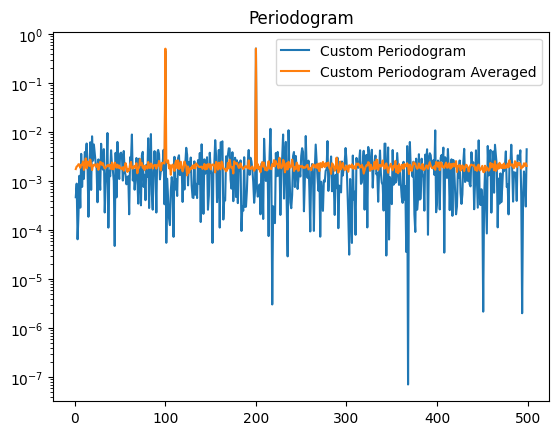

In [32]:
L = 50

I_ = []

for l in range(L):
    #Generate signal
    w = np.random.normal(0, 1, N)
    x = np.sin(2*np.pi*f_1*t)+np.sin(2*np.pi*f_2*t)
    x += w
    
    # Generate custom Periodogram
    X = np.fft.fft(x)
    I = 2*Ts*(1/N) * np.abs(X)**2
    freqs = np.fft.fftfreq(N, Ts)
    I_ += [I]

I_avg = np.vstack(I_)
I_avg = np.mean(I_avg, axis=0)

idx_plot = freqs > 0

plt.figure()
plt.plot(freqs[idx_plot], I[idx_plot], label="Custom Periodogram")
plt.plot(freqs[idx_plot], I_avg[idx_plot], label="Custom Periodogram Averaged")
plt.title("Periodogram")
plt.legend()
plt.yscale("log")

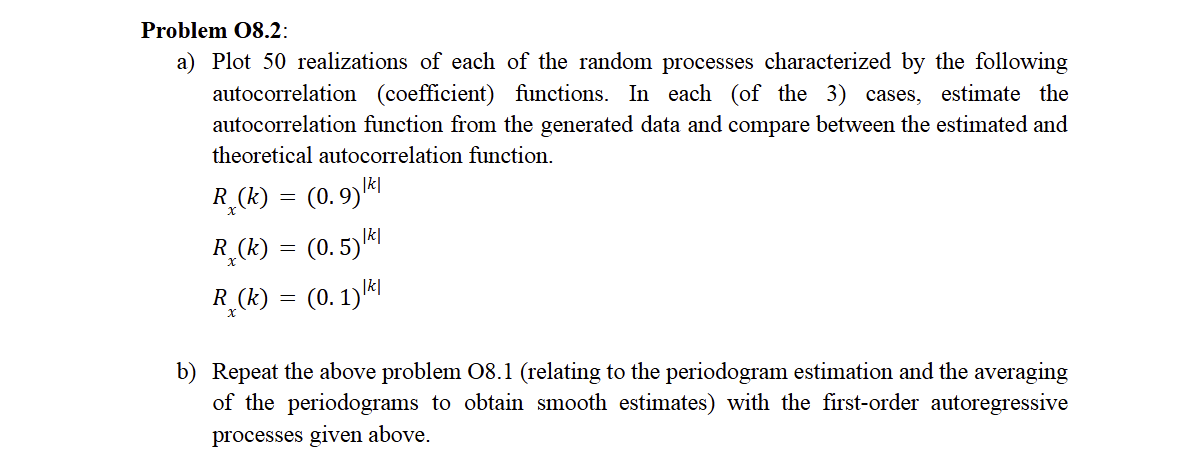

### a and b)

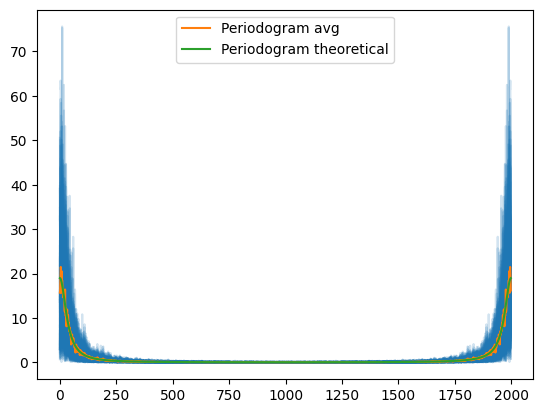

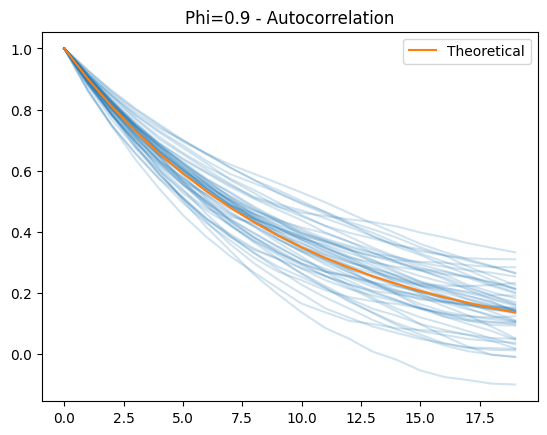

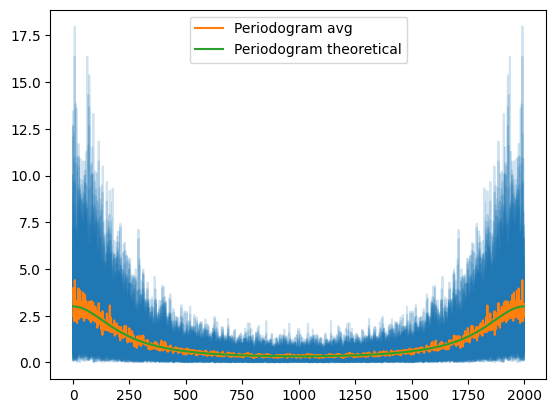

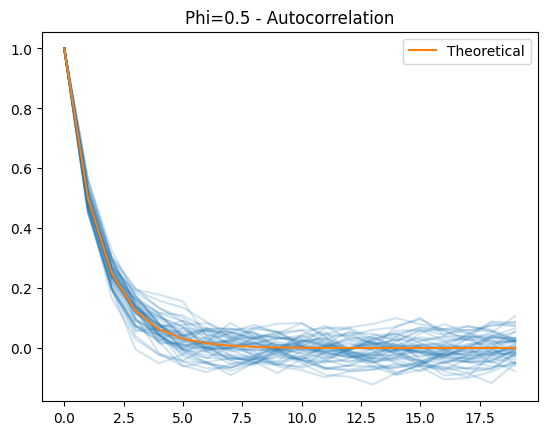

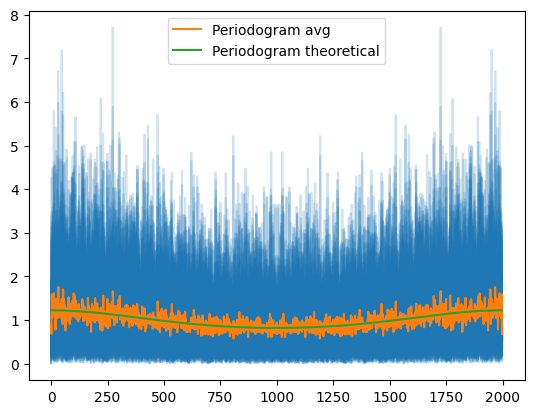

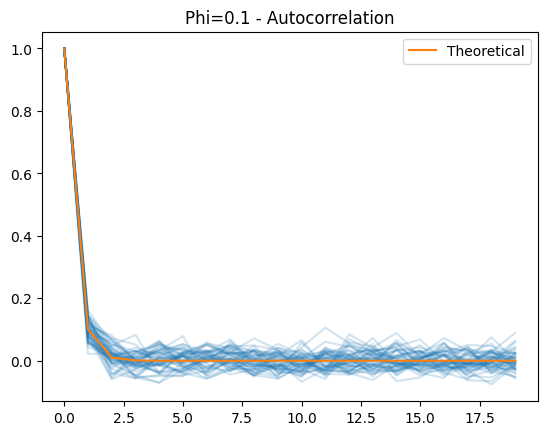

In [114]:
from statsmodels.tsa.stattools import acf

L = 50
nlags = 20
phis = [0.9, 0.5, 0.1]

def ar_one(w, phi):

    x = np.zeros_like(w)

    x[0] = w[0]
    for i in range(1, len(w)):
        x[i] = phi * x[i-1] + w[i]
    return x

for phi in phis:

    acorr_ = []
    
    for l in range(L):

        w = np.random.normal(0, 1, N)
        x = ar_one(w, phi)

        #acorr = acf(x, nlags=nlags)
        raw_acov = np.correlate(x, x, mode='full')# / N
        # Normalize to get autocorrelation
        raw_acov = raw_acov / np.max(raw_acov)
        
        acorr_ += [raw_acov]

    plot_lags = 20
    acorr_plot_start = N-1

    # The roll is nescassary to get an even function(According to Numpy)
    theoretical_acorr = np.roll([phi**lag for lag in range(N)][1:][::-1] + [phi**lag for lag in range(N)], N)
    acorr_ = np.roll(np.vstack(acorr_), N)

    # We get the periodogram by calculating the FFT from -(N-1) to N-1
    # Then we take the real part of the result. In theory, it is not nescasary to take the
    # real part since the autocorrelation is even and real values, but we not it because of numerical noise
    periodogram = np.real(np.fft.fft(acorr_))
    periodogram_avg = np.mean(periodogram, axis=0)

    
    theoretical_periodogram = np.fft.fft(theoretical_acorr)

    '''
    plt.figure()
    plt.plot(acorr_.T[acorr_plot_start:acorr_plot_start+plot_lags], color="C0", alpha=0.2)
    plt.plot(theoretical_acorr[:plot_lags], label="Theoretical", color="C1")
    plt.title(f"Phi={phi} - Autocorrelation")
    plt.legend()  
    '''
    
    plt.figure()
    plt.plot(periodogram.T, color="C0", alpha=0.2)
    plt.plot(periodogram_avg, label="Periodogram avg", color="C1")
    plt.plot(theoretical_periodogram, label="Periodogram theoretical", color="C2")
    plt.legend()  

    plt.figure()
    plt.plot(acorr_.T[:20], color="C0", alpha=0.2)
    plt.plot(theoretical_acorr[:20], label="Theoretical", color="C1")
    plt.legend()  
    plt.title(f"Phi={phi} - Autocorrelation")

    

### b)